## SPAN-ion VDF Plotting

The SPAN-ion instrument is a part of the SWEAP instrument suite on board the Parker Solar Probe dedicated to measuring the thermal component of the plasma making up the solar wind. It is a top-hat style electrostatic analyzer with an additional set of plates at the incoming aperrture allowing for deflection of the incoming beam. For information on the inner workings and operation of this instrument, please see the SWEAP Data Users Guide:
 - XXX -
or the instrument paper:
 - XXX -

The SPAN and SPC instruments work together to measure the plasma distribution during different periods of the spacecraft orbit. There are various factors that contribute to one measurement being a better representation of the solar wind plasma than the other, and the user is encouraged to reach out to the instrument teams to verify data quality. As a first pass, users can learn more about the relative fields of view and measurement capabilities here:
 - XXX -

This guide will explore the process of plotting a velocity distribution function as measured by the SPAN-ion instrument. At each timestamp, the SPAN-ion instrument will sweep across deflection angles (split into 8 channel bins), sweep through 32 voltage ranges (restricting the energy of incoming ions), and record measurements at each anode (split into 8 bins for the sf00 product). Together, these generate a 3-dimensional array of 8x32x8 values making up a distribution function of the plasma over the measurement timerange.

Our goal for this exercise will be to examine the file and variable properties of Level-2 SPAN-ion data, and generate plots of the velocity distribution function.

In [5]:
# Below are the necessary packages for reading and plotting our data.
# They can be installed with pip
from spacepy import pycdf 
import spacepy.plot as splot
import wget
import numpy as np

# These lines are simply to suppress package deprecation warnings displayed in jupyter notebooks
from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

Let's download some data! We will start with a particular file harcoded in for now, and will later populate the filename with wildcards. The if/else loops below simply exist to make sure we don't keep downloading the same file repeatedly. Using pycdf from the spacepy package, we can examine the list of variables included as well as their array lengths.

In [6]:
VDfile_directoryRemote = 'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf00/2020/01/'
VDfile_filename = 'psp_swp_spi_sf00_L2_8Dx32Ex8A_20200129_v03.cdf'

import os.path

if os.path.isfile(VDfile_filename):
    print("File exists")
    VDfile = VDfile_filename
else:
    print("File doesn't exist, do you exist?")
    VDfile = wget.download(VDfile_directoryRemote + VDfile_filename)

cdf_VDfile = pycdf.CDF(VDfile)

print(cdf_VDfile)

File exists
APID: CDF_UINT2 [12359]
ARCH_BITS: CDF_UINT1 [12359]
CNTS: CDF_FLOAT [12359]
COMPR_RATIO: CDF_FLOAT [12359]
DATA: CDF_FLOAT [12359, 2048]
DATASIZE: CDF_UINT4 [12359]
EFLUX: CDF_FLOAT [12359, 2048]
ENERGY: CDF_FLOAT [12359, 2048]
Epoch: CDF_TIME_TT2000 [12359]
F0: CDF_UINT2 [12359]
GAP: CDF_UINT1 [12359]
LTCSNNNN_BITS: CDF_UINT1 [12359]
MET: CDF_DOUBLE [12359]
MODE2: CDF_UINT2 [12359]
MODE2_ORI: CDF_UINT2 [12359]
NDAT: CDF_UINT4 [12359]
NUM_ACCUM: CDF_UINT4 [12359]
NUM_TOTAL: CDF_UINT4 [12359]
PEAK_BIN: CDF_UINT1 [12359]
PHI: CDF_FLOAT [12359, 2048]
PKT_SIZE: CDF_UINT4 [12359]
PRODUCT_BITS: CDF_UINT1 [12359]
QUALITY_FLAG: CDF_UINT2 [12359]
ROTMAT_SC_INST: CDF_FLOAT [3, 3] NRV
SEQN: CDF_UINT2 [12359]
SEQN_DELTA: CDF_UINT2 [12359]
SEQN_GROUP: CDF_UINT1 [12359]
SOURCE_APID: CDF_UINT2 [12359]
SOURCE_HASH: CDF_UINT4 [12359]
STATUS_BITS: CDF_UINT1 [12359]
THETA: CDF_FLOAT [12359, 2048]
TIME: CDF_DOUBLE [12359]
TIME_ACCUM: CDF_DOUBLE [12359]
TIME_TOTAL: CDF_DOUBLE [12359]


We can see that this particular file has 12359 records for most of the variables, each associated with the timestamps given by the Epoch variable. We can extract datasets into arrays by calling the keys listed above in reference to the parsed cdf file:

In [7]:
epoch           = cdf_VDfile['Epoch']
theta           = cdf_VDfile['THETA']
phi             = cdf_VDfile['PHI']
energy          = cdf_VDfile['ENERGY']
eflux           = cdf_VDfile['EFLUX']
rotMat          = cdf_VDfile['ROTMAT_SC_INST']

The 'Epoch' variable in a cdf is standardized to a particular time format defined by nanoseconds since 2000-01-01 12:00:00. One of the reasons we have used pycdf as our cdf reader is that it will automatically import the 'Epoch' variable into an array of datetime objects. This saves us a couple of steps if we want to easily integrate 'Epoch' into plotting routines and analysis.

Since we are only interested in looking at a single distribution function (or a distribution averaged over a limited amount of time) we can isolate a subset of the arrays above.

In [8]:
import datetime
import bisect
#            datetime.datetime(YYYY, mm, dd, HH, MM, SS)
timeSlice  = datetime.datetime(2020,  1, 29, 18, 10,  2)
print('Desired timeslice:',timeSlice)
print('time slice:',timeSlice)

tSliceIndex  = bisect.bisect_left(epoch, timeSlice)
print('time Index:',tSliceIndex)
print('Time of closest data point:',epoch[tSliceIndex])

Desired timeslice: 2020-01-29 18:10:02
time slice: 2020-01-29 18:10:02
time Index: 9355
Time of closest data point: 2020-01-29 18:10:02.709164


Pulling a single slice of the arrays at the given time is a simple array call using the index value we found with `bisect` above:

In [9]:
epochSlice  = epoch[ tSliceIndex]
thetaSlice  = theta[ tSliceIndex,:]
phiSlice    = phi[   tSliceIndex,:]
energySlice = energy[tSliceIndex,:]
efluxSlice  = eflux[ tSliceIndex,:]

Recall we stated the instrument steps first through deflection angles (theta), then at each theta sweeps in energy by changing the voltage applied to the electrostatic plates (energy), then records measurements made on each of 8 anode channels (phi). These combine for a total of 8*32*8=2048 values at each point in time. We can reshape the rank1 [2048] arrays into rank3 [8, 32, 8] arrays to better identify and differentiate each of these steps.

In [12]:
thetaReshaped = thetaSlice.reshape((8,32,8))
phiReshaped = phiSlice.reshape((8,32,8))
energyReshaped = energySlice.reshape((8,32,8))
efluxReshaped = efluxSlice.reshape((8,32,8))

print(thetaReshaped.shape)

(8, 32, 8)


Now, we convert the energyflux parameter (the amount of energy deposited at each anode as a function of area) to velocity distribution units. We do this by first normalizing the energy flux by the energy setting of the voltage sweep to resolve the number of particles incident at each measurement

In [13]:
mass_p = 0.010438870      #eV/c^2 where c = 299792 km/s
charge_p = 1              #eV

#Define VDF
numberFlux = efluxReshaped/energyReshaped
vdf = numberFlux*(mass_p**2)/((2E-5)*energyReshaped)

#Convert to velocity units in each energy channel
vel = np.sqrt(2*charge_p*energyReshaped/mass_p)

We can rotate out of the pure instrument notation and into a cartesian velocity system using basic trigonometry. The vector length in this case is the velocity at each point derived from the energy above. The vector velocity in instrument coordinates comes out to:
```
vx = velocity * cos(theta) * cos(phi)
vy = velocity * cos(theta) * sin(phi)
vz = velocity * sin(theta)
```

In [14]:
vx = vel * np.cos(np.radians(thetaReshaped)) * np.cos(np.radians(phiReshaped))
vy = vel * np.cos(np.radians(thetaReshaped)) * np.sin(np.radians(phiReshaped))
vz = vel * np.sin(np.radians(thetaReshaped))

Finally, we will plot the vellocity distribution in the vx/vz plane. This plane corresponds to the 

Currently the vdf is taken as a slice at theta=0 or something like that. Ideally, we would collapse the whole distribution. This is not a trivial process and will affect the final product slightly depending on how you interpolate between angular bins. Choices in that regard are also ongoing.

Not sure why the slice is different from the averaged plot. Averaging the Vx/Vz portion is probably a dumb move, but I can't directly identify why.

(8, 32, 8)


<ipython-input-37-628475e8a25b>:9: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_TEMP, vz_TEMP, vdf_TEMP,locator=ticker.LogLocator(),cmap=cm.cool)
<ipython-input-37-628475e8a25b>:21: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_TEMP, vz_TEMP, vdf_TEMP,locator=ticker.LogLocator(),cmap=cm.cool)


(-500.0, 500.0)

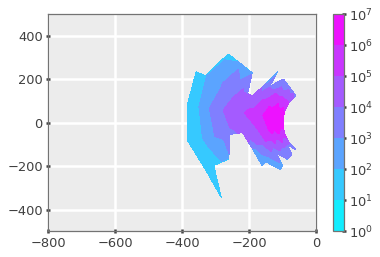

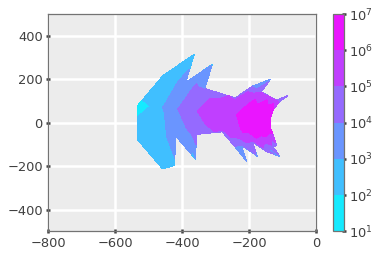

In [37]:
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
print(vdf.shape)
vdf_TEMP = np.mean(vdf, axis=(0))
vx_TEMP  = np.mean(vx, axis=(0))
vz_TEMP  = np.mean(vz, axis=(0))

fig,ax=plt.subplots()
cs=ax.contourf(vx_TEMP, vz_TEMP, vdf_TEMP,locator=ticker.LogLocator(),cmap=cm.cool)
cbar = fig.colorbar(cs)
ax.set_xlim(-800,0)
ax.set_ylim(-500,500)


thetaSlice = 2
vdf_TEMP = vdf[thetaSlice,:,:]
vx_TEMP  = vx[ thetaSlice,:,:]
vz_TEMP  = vz[ thetaSlice,:,:]

fig,ax=plt.subplots()
cs=ax.contourf(vx_TEMP, vz_TEMP, vdf_TEMP,locator=ticker.LogLocator(),cmap=cm.cool)
cbar = fig.colorbar(cs)
ax.set_xlim(-800,0)
ax.set_ylim(-500,500)


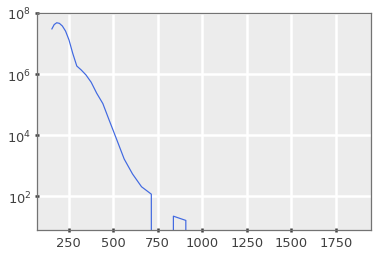

In [14]:
import matplotlib.pyplot as plt

thetaSlice = 3
plt.plot(vel[0,:,0],vdf_allAngles)
plt.yscale('log')


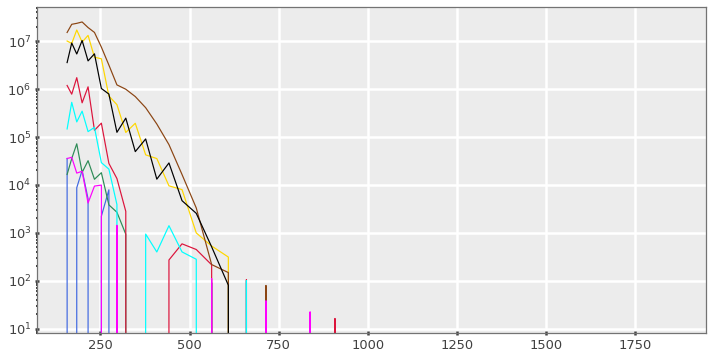

In [23]:

#plt.plot(vx_allEnergies[:,:],vdf_allEnergies[:,:])
#plt.yscale('log')
vdf_allThetas = np.sum(vdf, axis=0)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(vel[0,:,:],vdf_allThetas)

ax.set_yscale('log')
ax.set_xlim=(0,1000)



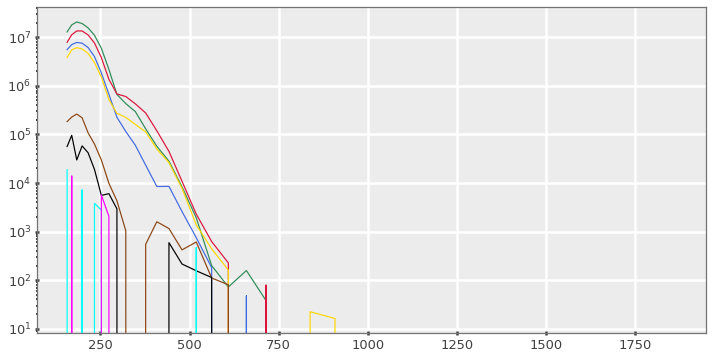

In [24]:
#vdf_allPhis = np.sum(vdf, axis=2)
#fig = plt.figure(figsize=(12, 6))
#ax = fig.add_subplot(111)
#ax.plot(vel[:,:,0],vdf_allPhis)

#ax.set_yscale('log')
#ax.set_xlim=(0,1000)

vdf_allPhis = np.sum(vdf, axis=2)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(np.transpose(vel[:,:,0]),np.transpose(vdf_allPhis))

ax.set_yscale('log')
ax.set_xlim=(0,1000)

In [17]:
print(vdf.shape)
print(vx.shape)

(8, 32, 8)
(8, 32, 8)


(32, 8)
(32, 8)
(32, 8)


<ipython-input-18-8eff6421777e>:27: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.cool)


(-500.0, 500.0)

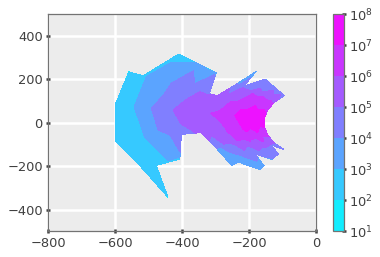

In [18]:
from matplotlib import ticker, cm

thetaplot_cut = 0
phiplot_cut = 2

#phi_avg = np.nanmean(phiReshaped,axis=thetaplot_cut)
#theta_avg = np.nanmean(thetaReshaped,axis=thetaplot_cut)
#energy_avg=np.nanmean(energyReshaped,axis=thetaplot_cut)

phi_plane = phiReshaped[0,:,:]
theta_plane = thetaReshaped[0,:,:]
energy_plane = energyReshaped[0,:,:]
vel_plane = np.sqrt(2*charge_p*energy_plane/mass_p)

df=np.nansum(vdf,axis=thetaplot_cut)
print(df.shape)


vx_plane = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vy_plane = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
vz_plane = vel_plane *                                   np.sin(np.radians(theta_plane))

print(vx_plane.shape)
print(vy_plane.shape)

fig,ax=plt.subplots()
cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.cool)
cbar = fig.colorbar(cs)
ax.set_xlim(-800,0)
ax.set_ylim(-500,500)




Now we can put it all together into a single plotting script where all we input is the timestamp:

In [1]:


def doitall(timeslice):

    from spacepy import pycdf 
    import spacepy.plot as splot
    import wget
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import ticker, cm
    import os.path
    
    year  = timeslice.year
    month = timeslice.month
    day   = timeslice.day
    
    if len(str(month)) < 2:
        month = '0'+str(month)


    from warnings import simplefilter 
    simplefilter(action='ignore', category=DeprecationWarning)

    #VDfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf00/{year}/{month}/'
    #VDfile_filename = f'psp_swp_spi_sf00_L2_8Dx32Ex8A_{year}{month}{day}_v03.cdf'
    
    localDirectory = f'G:/My Drive/Research/Data/AutoplotCache/http/w3sweap.cfa.harvard.edu/data/sci/sweap/spi/L2/spi_sf00/{year}/{month}/'
    localDirectoryPub = f'G:/My Drive/Research/Data/AutoplotCache/http/w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf00/{year}/{month}/'
    
    
    #This will be a terrible way to do this, but it should at least work (for a while, anyway)
    versionList = ['09', '08', '07', '06', '05', '04', '03', '02', '01', '00']

    versionTest = 'notFound'
    for version in versionList:
        if versionTest == 'notFound':
            VDfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf00/{year}/{month}/'
            VDfile_filename = f'psp_swp_spi_sf00_L2_8Dx32Ex8A_{year}{month}{day}_v{version}.cdf'
            
            # Redefine these for using non-public data
            VDfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/data/sci/sweap/spi/L2/spi_sf00/{year}/{month}/'
            #VDfile_filename = f'spp_swp_spi_sf00_L2_8Dx32Ex8A_{year}{month}{day}_v{version}.cdf'
            
            
            if os.path.isfile(localDirectory + VDfile_filename):
                print(f"Version {version} exists")
                VDfile = localDirectory + VDfile_filename
                versionTest = 'found'
            else:
                try:
                    #print(f"Version {version} doesn't exist locally, searching online..")
                    #print(VDfile_directoryRemote + VDfile_filename)
                    #print(localDirectory + VDfile_filename)
                    VDfile = wget.download(VDfile_directoryRemote + VDfile_filename + ' -P ' + localDirectory)
                    versionTest = 'found'
                    print(f'Grabbed version {version}')
                except:
                    continue
        elif versionTest == 'found':
            break

    cdf_VDfile = pycdf.CDF(VDfile)

    epoch           = cdf_VDfile['Epoch']
    theta           = cdf_VDfile['THETA']
    phi             = cdf_VDfile['PHI']
    energy          = cdf_VDfile['ENERGY']
    eflux           = cdf_VDfile['EFLUX']
    rotMat          = cdf_VDfile['ROTMAT_SC_INST']

    print('Desired timeslice:',timeslice)
    import bisect
    tSliceIndex  = bisect.bisect_left(epoch, timeslice)
    print('time Index:',tSliceIndex)
    print('Time of closest data point:',epoch[tSliceIndex])

    epochSlice  = epoch[tSliceIndex]
    thetaSlice  = theta[tSliceIndex,:]
    phiSlice    = phi[tSliceIndex,:]
    energySlice = energy[tSliceIndex,:]
    efluxSlice  = eflux[tSliceIndex,:]

    thetaReshaped = thetaSlice.reshape((8,32,8))
    phiReshaped = phiSlice.reshape((8,32,8))
    energyReshaped = energySlice.reshape((8,32,8))
    efluxReshaped = efluxSlice.reshape((8,32,8))

    mass_p = 0.010438870      #eV/c^2 where c = 299792 km/s
    charge_p = 1              #eV

    #Define VDF
    numberFlux = efluxReshaped/energyReshaped
    vdf = numberFlux*(mass_p**2)/((2E-5)*energyReshaped)

    #Convert to velocity units in each energy channel
    vel = np.sqrt(2*charge_p*energyReshaped/mass_p)

    vx = vel * np.cos(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
    vy = vel * np.sin(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
    vz = vel *                                   np.sin(np.radians(thetaReshaped))


    thetaplot_cut = 0
    phiplot_cut = 2

    #phi_avg = np.nanmean(phiReshaped,axis=thetaplot_cut)
    #theta_avg = np.nanmean(thetaReshaped,axis=thetaplot_cut)
    #energy_avg=np.nanmean(energyReshaped,axis=thetaplot_cut)

    phi_plane = phiReshaped[0,:,:]
    theta_plane = thetaReshaped[0,:,:]
    energy_plane = energyReshaped[0,:,:]
    vel_plane = np.sqrt(2*charge_p*energy_plane/mass_p)

    df=np.nansum(vdf,axis=thetaplot_cut)
    

    vx_plane = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vy_plane = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vz_plane = vel_plane *                                   np.sin(np.radians(theta_plane))

    fig,ax=plt.subplots()
    cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.cool)
    cbar = fig.colorbar(cs)
    ax.set_xlim(-800,0)
    ax.set_ylim(-500,500)
    ax.set_title(epoch[tSliceIndex].isoformat(timespec='seconds'))



Version 04 exists
Desired timeslice: 2021-11-22 01:28:53
time Index: 763
Time of closest data point: 2021-11-22 01:28:58.151206


<ipython-input-1-5c553716b07f>:121: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.cool)


Version 04 exists
Desired timeslice: 2021-11-22 02:04:41
time Index: 1070
Time of closest data point: 2021-11-22 02:04:44.244909


<ipython-input-1-5c553716b07f>:121: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.cool)


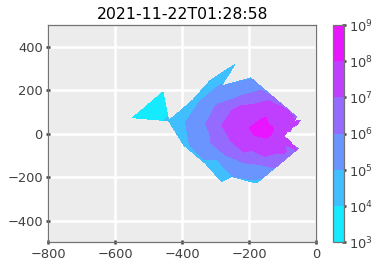

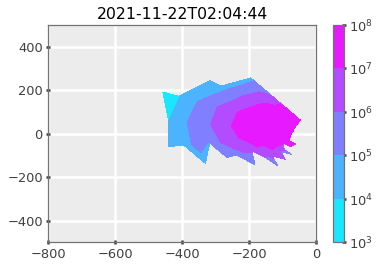

In [2]:

import datetime
# datetime(YYYY, mm, dd, HH, MM)
#timeSlice  = datetime.datetime(2020, 1, 29, 18, 10, 2)   # Original test slice
timeSlice  = datetime.datetime(2021, 11, 22, 1, 28, 53)   

doitall(timeSlice)
#timeSlice  = datetime.datetime(2021, 1, 20, 4, 57, 38)   # Period of high trat?
timeSlice  = datetime.datetime(2021, 11, 22, 2, 4, 41)
doitall(timeSlice)

In [6]:


def doitallRange(yyyy=2021, mm=1, dd=20, HH=2, MM=14, SS=30, deltaSeconds=10, species='H+'):
    
    
    
    import datetime
    timeStart  = datetime.datetime(yyyy, mm, dd, HH, MM, SS) - datetime.timedelta(seconds=deltaSeconds/2.)
    timeEnd  = timeStart + datetime.timedelta(seconds=deltaSeconds)

    from spacepy import pycdf 
    import spacepy.plot as splot
    import wget
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import ticker, cm
    import os.path
    
    timeslice = timeStart
    
    year  = timeslice.year
    month = timeslice.month
    day   = timeslice.day
    
    if len(str(month)) < 2:
        month = '0'+str(month)
        
    if species == 'H+' or species == 'H':
        speciesTag = '00'
        if species == 'H':
            species = 'H+'
    elif species == 'He++' or species == 'He':
        speciesTag = '01'
        if species == 'He':
            species = 'He++'


    from warnings import simplefilter 
    simplefilter(action='ignore', category=DeprecationWarning)

    #VDfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf00/{year}/{month}/'
    #VDfile_filename = f'psp_swp_spi_sf00_L2_8Dx32Ex8A_{year}{month}{day}_v03.cdf'
    
    localDirectory = f'G:/My Drive/Research/Data/AutoplotCache/http/w3sweap.cfa.harvard.edu/data/sci/sweap/spi/L2/spi_sf{speciesTag}/{year}/{month}/'
    localDirectoryPub = f'G:/My Drive/Research/Data/AutoplotCache/http/w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf{speciesTag}/{year}/{month}/'
    
    
    #This will be a terrible way to do this, but it should at least work (for a while, anyway)
    versionList = ['09', '08', '07', '06', '05', '04', '03', '02', '01', '00']

    versionTest = 'notFound'
    for version in versionList:
        if versionTest == 'notFound':
            VDfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf{speciesTag}/{year}/{month}/'
            VDfile_filename = f'psp_swp_spi_sf{speciesTag}_L2_8Dx32Ex8A_{year}{month}{day}_v{version}.cdf'
            
            
            if os.path.isfile(localDirectory + VDfile_filename):
                #print(f"Version {version} exists")
                VDfile = localDirectory + VDfile_filename
                versionTest = 'found'
            else:
                try:
                    #print(f"Version {version} doesn't exist locally, searching online..")
                    #print(VDfile_directoryRemote + VDfile_filename)
                    #print(localDirectory + VDfile_filename)
                    VDfile = wget.download(VDfile_directoryRemote + VDfile_filename + ' -P ' + localDirectory)
                    versionTest = 'found'
                    #print(f'Grabbed version {version}')
                except:
                    continue
        elif versionTest == 'found':
            break

    cdf_VDfile = pycdf.CDF(VDfile)

    epoch           = cdf_VDfile['Epoch']
    theta           = cdf_VDfile['THETA']
    phi             = cdf_VDfile['PHI']
    energy          = cdf_VDfile['ENERGY']
    eflux           = cdf_VDfile['EFLUX']
    rotMat          = cdf_VDfile['ROTMAT_SC_INST']

    print('Desired timerange:',timeStart, ' to ', timeEnd)
    import bisect
    tSliceIndex_start  = bisect.bisect_left(epoch, timeStart)
    tSliceIndex_end    = bisect.bisect_right(epoch, timeEnd)
    tSliceIndex = tSliceIndex_start+int((tSliceIndex_end-tSliceIndex_start)/2.)
    #print('time Index Start:',tSliceIndex_start)
    #print('time Index End:',tSliceIndex_end)
    print('Time of closest start data point:',epoch[tSliceIndex_start])
    print('Time of closest end data point:',epoch[tSliceIndex_end])

    #print(timeEnd - timeStart)
    epochSlice  = epoch[tSliceIndex]
    #print(epochSlice)
    thetaSlice  = theta[tSliceIndex_start:tSliceIndex_end].mean(axis=0)
    phiSlice    = phi[tSliceIndex_start:tSliceIndex_end].mean(axis=0)
    energySlice = energy[tSliceIndex_start:tSliceIndex_end].mean(axis=0)
    efluxSlice  = eflux[tSliceIndex_start:tSliceIndex_end].mean(axis=0)

    thetaReshaped = thetaSlice.reshape((8,32,8))
    phiReshaped = phiSlice.reshape((8,32,8))
    energyReshaped = energySlice.reshape((8,32,8))
    efluxReshaped = efluxSlice.reshape((8,32,8))

    mass_p = 0.010438870      #eV/c^2 where c = 299792 km/s
    charge_p = 1              #eV

    #Define VDF
    numberFlux = efluxReshaped/energyReshaped
    vdf = numberFlux*(mass_p**2)/((2E-5)*energyReshaped)

    #Convert to velocity units in each energy channel
    vel = np.sqrt(2*charge_p*energyReshaped/mass_p)

    vx = vel * np.cos(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
    vy = vel * np.sin(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
    vz = vel *                                   np.sin(np.radians(thetaReshaped))


    thetaplot_cut = 0
    phiplot_cut = 2

    #phi_avg = np.nanmean(phiReshaped,axis=thetaplot_cut)
    #theta_avg = np.nanmean(thetaReshaped,axis=thetaplot_cut)
    #energy_avg=np.nanmean(energyReshaped,axis=thetaplot_cut)

    phiAngle_sliceIndex = 0
    
    phi_plane = phiReshaped[phiAngle_sliceIndex,:,:]
    theta_plane = thetaReshaped[phiAngle_sliceIndex,:,:]
    energy_plane = energyReshaped[phiAngle_sliceIndex,:,:]
    vel_plane = np.sqrt(2*charge_p*energy_plane/mass_p)

    df=np.nansum(vdf,axis=thetaplot_cut)
    

    vx_plane = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vy_plane = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vz_plane = vel_plane *                                   np.sin(np.radians(theta_plane))
    
    vmin = 1
    vmax = 8
    levels = np.logspace(vmin, vmax, (2*(vmax-vmin))+1)
    fig,ax=plt.subplots()
    cs=ax.contourf(vx_plane, vz_plane, df, locator=ticker.LogLocator(numticks=(vmax-vmin)+1), cmap=cm.turbo, levels=levels)
    cbar = fig.colorbar(cs)
    ax.set_xlim(-1200,0)
    ax.set_ylim(-700,700)
    ax.set_xlabel('Vx (km/s) [~RTN R]')
    ax.set_ylabel('Vz (km/s) [~RTN N]')
    cbar.set_label('VDF ($cm^{-3} km^{-1} s$)')
    ax.set_title(str(epoch[tSliceIndex].isoformat(timespec='seconds'))+f' +/- {(timeEnd - timeStart)/2}   '+species)
    plt.show()



discrete alpha peak region
Desired timerange: 2022-02-25 12:35:00  to  2022-02-25 12:37:00
Time of closest start data point: 2022-02-25 12:35:00.774469
Time of closest end data point: 2022-02-25 12:37:01.361291


<ipython-input-6-2878c21849a1>:145: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df, locator=ticker.LogLocator(numticks=(vmax-vmin)+1), cmap=cm.turbo, levels=levels)


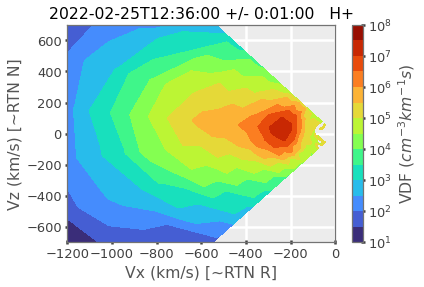

UnboundLocalError: local variable 'VDfile' referenced before assignment

In [7]:
print('discrete alpha peak region')
doitallRange(2022, 2, 25, 12, 36, 0, 120, species='H') 
doitallRange(2022, 2, 25, 12, 36, 0, 120, species='He') 

Before the wave event
Desired timerange: 2021-11-22 02:31:30  to  2021-11-22 02:33:30
Time of closest start data point: 2021-11-22 02:31:32.067575
Time of closest end data point: 2021-11-22 02:33:30.906596


<ipython-input-78-2878c21849a1>:145: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df, locator=ticker.LogLocator(numticks=(vmax-vmin)+1), cmap=cm.turbo, levels=levels)


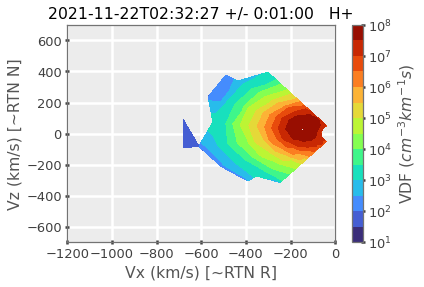

Desired timerange: 2021-11-22 02:31:30  to  2021-11-22 02:33:30
Time of closest start data point: 2021-11-22 02:31:32.067575
Time of closest end data point: 2021-11-22 02:33:30.906596


<ipython-input-78-2878c21849a1>:145: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df, locator=ticker.LogLocator(numticks=(vmax-vmin)+1), cmap=cm.turbo, levels=levels)


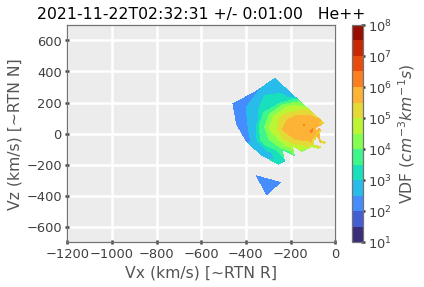

Anti-Sunward Propagation
Desired timerange: 2021-11-22 02:39:30  to  2021-11-22 02:41:30
Time of closest start data point: 2021-11-22 02:39:34.414341
Time of closest end data point: 2021-11-22 02:41:33.253422


<ipython-input-78-2878c21849a1>:145: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df, locator=ticker.LogLocator(numticks=(vmax-vmin)+1), cmap=cm.turbo, levels=levels)


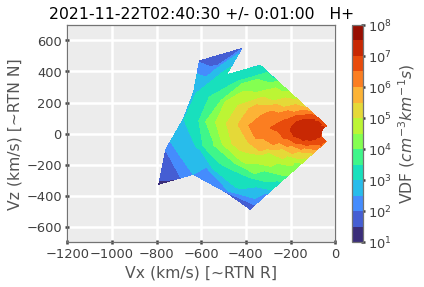

Desired timerange: 2021-11-22 02:39:30  to  2021-11-22 02:41:30
Time of closest start data point: 2021-11-22 02:39:30.919041
Time of closest end data point: 2021-11-22 02:41:33.253422


<ipython-input-78-2878c21849a1>:145: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df, locator=ticker.LogLocator(numticks=(vmax-vmin)+1), cmap=cm.turbo, levels=levels)


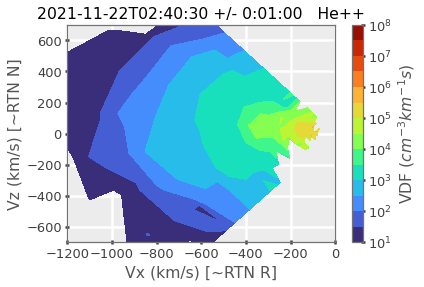

Sunward Propagation
Desired timerange: 2021-11-22 02:44:30  to  2021-11-22 02:46:30
Time of closest start data point: 2021-11-22 02:44:35.007235
Time of closest end data point: 2021-11-22 02:46:33.846296


<ipython-input-78-2878c21849a1>:145: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df, locator=ticker.LogLocator(numticks=(vmax-vmin)+1), cmap=cm.turbo, levels=levels)


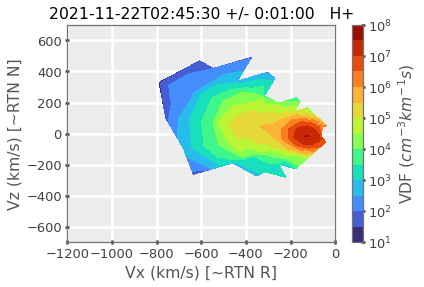

Desired timerange: 2021-11-22 02:44:30  to  2021-11-22 02:46:30
Time of closest start data point: 2021-11-22 02:44:31.511994
Time of closest end data point: 2021-11-22 02:46:30.351055


<ipython-input-78-2878c21849a1>:145: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df, locator=ticker.LogLocator(numticks=(vmax-vmin)+1), cmap=cm.turbo, levels=levels)


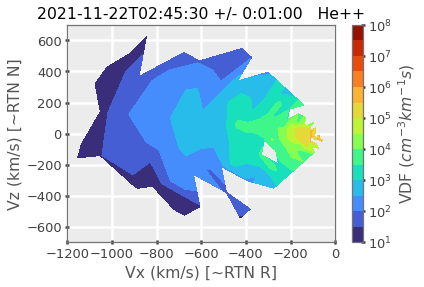

Anti-Sunward Propagation
Desired timerange: 2021-11-22 02:48:10  to  2021-11-22 02:50:10
Time of closest start data point: 2021-11-22 02:48:11.713813
Time of closest end data point: 2021-11-22 02:50:10.552814


<ipython-input-78-2878c21849a1>:145: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df, locator=ticker.LogLocator(numticks=(vmax-vmin)+1), cmap=cm.turbo, levels=levels)


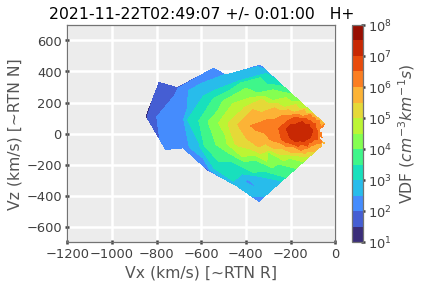

Desired timerange: 2021-11-22 02:48:10  to  2021-11-22 02:50:10
Time of closest start data point: 2021-11-22 02:48:11.713813
Time of closest end data point: 2021-11-22 02:50:10.552814


<ipython-input-78-2878c21849a1>:145: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df, locator=ticker.LogLocator(numticks=(vmax-vmin)+1), cmap=cm.turbo, levels=levels)


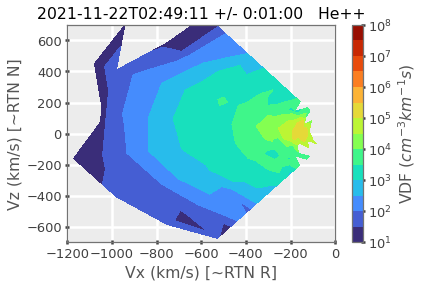

Sunward Propagation
Desired timerange: 2021-11-22 02:50:30  to  2021-11-22 02:52:30
Time of closest start data point: 2021-11-22 02:50:31.524438
Time of closest end data point: 2021-11-22 02:52:30.363519


<ipython-input-78-2878c21849a1>:145: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df, locator=ticker.LogLocator(numticks=(vmax-vmin)+1), cmap=cm.turbo, levels=levels)


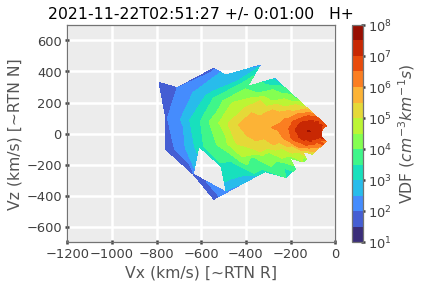

Desired timerange: 2021-11-22 02:50:30  to  2021-11-22 02:52:30
Time of closest start data point: 2021-11-22 02:50:31.524438
Time of closest end data point: 2021-11-22 02:52:30.363519


<ipython-input-78-2878c21849a1>:145: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df, locator=ticker.LogLocator(numticks=(vmax-vmin)+1), cmap=cm.turbo, levels=levels)


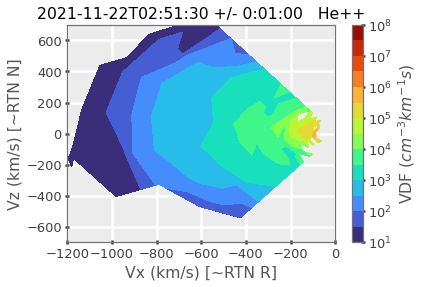

? Propagation
Desired timerange: 2021-11-22 02:53:00  to  2021-11-22 02:55:00
Time of closest start data point: 2021-11-22 02:53:05.316166
Time of closest end data point: 2021-11-22 02:55:04.155227


<ipython-input-78-2878c21849a1>:145: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df, locator=ticker.LogLocator(numticks=(vmax-vmin)+1), cmap=cm.turbo, levels=levels)


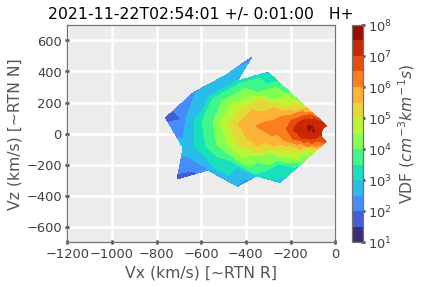

Desired timerange: 2021-11-22 02:53:00  to  2021-11-22 02:55:00
Time of closest start data point: 2021-11-22 02:53:01.820925
Time of closest end data point: 2021-11-22 02:55:00.659986


<ipython-input-78-2878c21849a1>:145: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df, locator=ticker.LogLocator(numticks=(vmax-vmin)+1), cmap=cm.turbo, levels=levels)


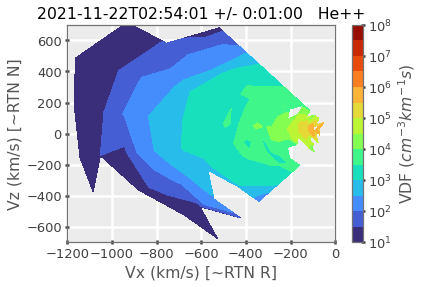

Sunward Propagation
Desired timerange: 2021-11-22 02:57:00  to  2021-11-22 02:59:00
Time of closest start data point: 2021-11-22 02:57:02.994308
Time of closest end data point: 2021-11-22 02:59:01.833369


<ipython-input-78-2878c21849a1>:145: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df, locator=ticker.LogLocator(numticks=(vmax-vmin)+1), cmap=cm.turbo, levels=levels)


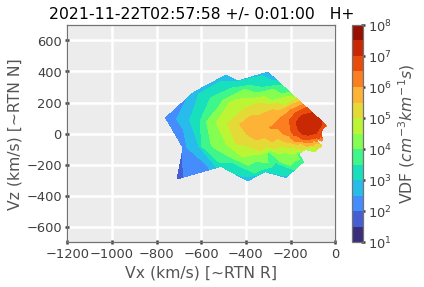

Desired timerange: 2021-11-22 02:57:00  to  2021-11-22 02:59:00
Time of closest start data point: 2021-11-22 02:57:02.994308
Time of closest end data point: 2021-11-22 02:59:01.833369


<ipython-input-78-2878c21849a1>:145: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df, locator=ticker.LogLocator(numticks=(vmax-vmin)+1), cmap=cm.turbo, levels=levels)


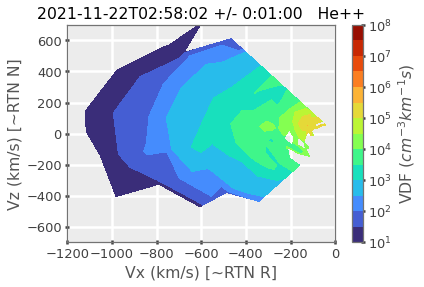

After Wave Event
Desired timerange: 2021-11-22 03:01:00  to  2021-11-22 03:03:00
Time of closest start data point: 2021-11-22 03:01:00.672450
Time of closest end data point: 2021-11-22 03:03:06.501993


<ipython-input-78-2878c21849a1>:145: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df, locator=ticker.LogLocator(numticks=(vmax-vmin)+1), cmap=cm.turbo, levels=levels)


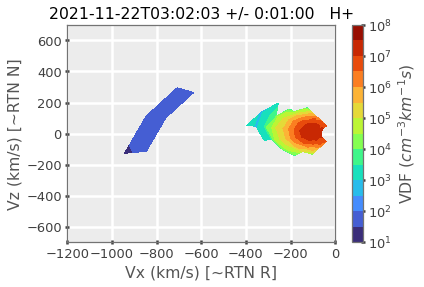

Desired timerange: 2021-11-22 03:01:00  to  2021-11-22 03:03:00
Time of closest start data point: 2021-11-22 03:01:00.672450
Time of closest end data point: 2021-11-22 03:03:03.006752


<ipython-input-78-2878c21849a1>:145: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df, locator=ticker.LogLocator(numticks=(vmax-vmin)+1), cmap=cm.turbo, levels=levels)


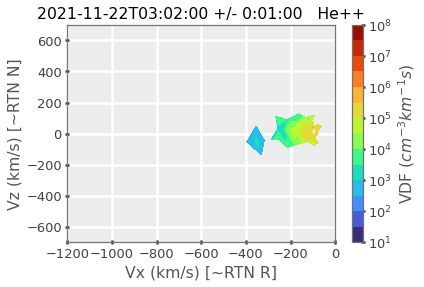

In [79]:
print('Before the wave event')
doitallRange(2021, 11, 22, 2, 32, 30, 120, species='H') 
doitallRange(2021, 11, 22, 2, 32, 30, 120, species='He') 
print('Anti-Sunward Propagation')
doitallRange(2021, 11, 22, 2, 40, 30, 120, species='H') 
doitallRange(2021, 11, 22, 2, 40, 30, 120, species='He') 
print('Sunward Propagation')
doitallRange(2021, 11, 22, 2, 45, 30, 120, species='H') 
doitallRange(2021, 11, 22, 2, 45, 30, 120, species='He') 
print('Anti-Sunward Propagation')
doitallRange(2021, 11, 22, 2, 49, 10, 120, species='H') 
doitallRange(2021, 11, 22, 2, 49, 10, 120, species='He') 
print('Sunward Propagation')
doitallRange(2021, 11, 22, 2, 51, 30, 120, species='H') 
doitallRange(2021, 11, 22, 2, 51, 30, 120, species='He') 
print('? Propagation')
doitallRange(2021, 11, 22, 2, 54, 0, 120, species='H') 
doitallRange(2021, 11, 22, 2, 54, 0, 120, species='He') 
print('Sunward Propagation')
doitallRange(2021, 11, 22, 2, 58, 0, 120, species='H') 
doitallRange(2021, 11, 22, 2, 58, 0, 120, species='He') 
print('After Wave Event')
doitallRange(2021, 11, 22, 3, 2, 0, 120, species='H') 
doitallRange(2021, 11, 22, 3, 2, 0, 120, species='He') 

In [ ]:


def doitallRangeInterpolation(yyyy=2021, mm=1, dd=20, HH=2, MM=14, SS=30, deltaSeconds=10, species='H+'):
    
    
    
    import datetime
    timeStart  = datetime.datetime(yyyy, mm, dd, HH, MM, SS) - datetime.timedelta(seconds=deltaSeconds/2.)
    timeEnd  = timeStart + datetime.timedelta(seconds=deltaSeconds)

    from spacepy import pycdf 
    import spacepy.plot as splot
    import wget
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import ticker, cm
    import os.path
    
    timeslice = timeStart
    
    year  = timeslice.year
    month = timeslice.month
    day   = timeslice.day
    
    if len(str(month)) < 2:
        month = '0'+str(month)
        
    if species == 'H+' or species == 'H':
        speciesTag = '00'
        if species == 'H':
            species = 'H+'
    elif species == 'He++' or species == 'He':
        speciesTag = '01'
        if species == 'He':
            species = 'He++'


    from warnings import simplefilter 
    simplefilter(action='ignore', category=DeprecationWarning)

    #VDfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf00/{year}/{month}/'
    #VDfile_filename = f'psp_swp_spi_sf00_L2_8Dx32Ex8A_{year}{month}{day}_v03.cdf'
    
    localDirectory = f'G:/My Drive/Research/Data/AutoplotCache/http/w3sweap.cfa.harvard.edu/data/sci/sweap/spi/L2/spi_sf{speciesTag}/{year}/{month}/'
    localDirectoryPub = f'G:/My Drive/Research/Data/AutoplotCache/http/w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf{speciesTag}/{year}/{month}/'
    
    
    #This will be a terrible way to do this, but it should at least work (for a while, anyway)
    versionList = ['09', '08', '07', '06', '05', '04', '03', '02', '01', '00']

    versionTest = 'notFound'
    for version in versionList:
        if versionTest == 'notFound':
            VDfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf{speciesTag}/{year}/{month}/'
            VDfile_filename = f'psp_swp_spi_sf{speciesTag}_L2_8Dx32Ex8A_{year}{month}{day}_v{version}.cdf'
            
            
            if os.path.isfile(localDirectory + VDfile_filename):
                #print(f"Version {version} exists")
                VDfile = localDirectory + VDfile_filename
                versionTest = 'found'
            else:
                try:
                    #print(f"Version {version} doesn't exist locally, searching online..")
                    #print(VDfile_directoryRemote + VDfile_filename)
                    #print(localDirectory + VDfile_filename)
                    VDfile = wget.download(VDfile_directoryRemote + VDfile_filename + ' -P ' + localDirectory)
                    versionTest = 'found'
                    #print(f'Grabbed version {version}')
                except:
                    continue
        elif versionTest == 'found':
            break

    cdf_VDfile = pycdf.CDF(VDfile)

    epoch           = cdf_VDfile['Epoch']
    theta           = cdf_VDfile['THETA']
    phi             = cdf_VDfile['PHI']
    energy          = cdf_VDfile['ENERGY']
    eflux           = cdf_VDfile['EFLUX']
    rotMat          = cdf_VDfile['ROTMAT_SC_INST']

    print('Desired timerange:',timeStart, ' to ', timeEnd)
    import bisect
    tSliceIndex_start  = bisect.bisect_left(epoch, timeStart)
    tSliceIndex_end    = bisect.bisect_right(epoch, timeEnd)
    tSliceIndex = tSliceIndex_start+int((tSliceIndex_end-tSliceIndex_start)/2.)
    #print('time Index Start:',tSliceIndex_start)
    #print('time Index End:',tSliceIndex_end)
    print('Time of closest start data point:',epoch[tSliceIndex_start])
    print('Time of closest end data point:',epoch[tSliceIndex_end])

    #print(timeEnd - timeStart)
    epochSlice  = epoch[tSliceIndex]
    #print(epochSlice)
    thetaSlice  = theta[tSliceIndex_start:tSliceIndex_end].mean(axis=0)
    phiSlice    = phi[tSliceIndex_start:tSliceIndex_end].mean(axis=0)
    energySlice = energy[tSliceIndex_start:tSliceIndex_end].mean(axis=0)
    efluxSlice  = eflux[tSliceIndex_start:tSliceIndex_end].mean(axis=0)

    thetaReshaped = thetaSlice.reshape((8,32,8))
    phiReshaped = phiSlice.reshape((8,32,8))
    energyReshaped = energySlice.reshape((8,32,8))
    efluxReshaped = efluxSlice.reshape((8,32,8))

    mass_p = 0.010438870      #eV/c^2 where c = 299792 km/s
    charge_p = 1              #eV

    #Define VDF
    numberFlux = efluxReshaped/energyReshaped
    vdf = numberFlux*(mass_p**2)/((2E-5)*energyReshaped)

    #Convert to velocity units in each energy channel
    vel = np.sqrt(2*charge_p*energyReshaped/mass_p)

    vx = vel * np.cos(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
    vy = vel * np.sin(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
    vz = vel *                                   np.sin(np.radians(thetaReshaped))


    thetaplot_cut = 0
    phiplot_cut = 2

    #phi_avg = np.nanmean(phiReshaped,axis=thetaplot_cut)
    #theta_avg = np.nanmean(thetaReshaped,axis=thetaplot_cut)
    #energy_avg=np.nanmean(energyReshaped,axis=thetaplot_cut)

    phi_plane = phiReshaped[0,:,:]
    theta_plane = thetaReshaped[0,:,:]
    energy_plane = energyReshaped[0,:,:]
    vel_plane = np.sqrt(2*charge_p*energy_plane/mass_p)

    df=np.nansum(vdf,axis=thetaplot_cut)
    

    vx_plane = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vy_plane = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vz_plane = vel_plane *                                   np.sin(np.radians(theta_plane))

    fig,ax=plt.subplots()
    cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.turbo)
    cbar = fig.colorbar(cs)
    ax.set_xlim(-1200,0)
    ax.set_ylim(-700,700)
    ax.set_title(str(epoch[tSliceIndex].isoformat(timespec='seconds'))+f' +/- {(timeEnd - timeStart)/2}   '+species)


Version {version} exists
Desired timerange: 2021-01-20 02:14:30  to  2021-01-20 02:14:40
time Index Start: 2309
time Index End: 2312
Time of closest start data point: 2021-01-20 02:14:32.901415
Time of closest end data point: 2021-01-20 02:14:43.387196
0:00:10
2021-01-20 02:14:36.396655


<ipython-input-21-ef48d9a400dc>:119: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.turbo)


Version {version} exists
Desired timerange: 2021-01-20 03:48:00  to  2021-01-20 03:48:10
time Index Start: 3914
time Index End: 3917
Time of closest start data point: 2021-01-20 03:48:02.797526
Time of closest end data point: 2021-01-20 03:48:13.283308
0:00:10
2021-01-20 03:48:06.292767


<ipython-input-21-ef48d9a400dc>:119: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.turbo)


Version {version} exists
Desired timerange: 2021-01-20 05:00:00  to  2021-01-20 05:00:10
time Index Start: 5150
time Index End: 5153
Time of closest start data point: 2021-01-20 05:00:02.941660
Time of closest end data point: 2021-01-20 05:00:13.427442
0:00:10
2021-01-20 05:00:06.436901


<ipython-input-21-ef48d9a400dc>:119: UserWarning: Log scale: values of z <= 0 have been masked
  cs=ax.contourf(vx_plane, vz_plane, df,locator=ticker.LogLocator(),cmap=cm.turbo)


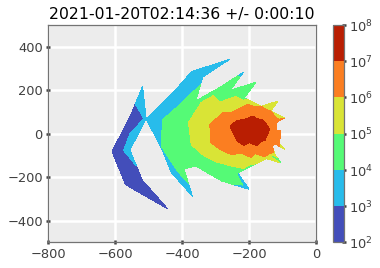

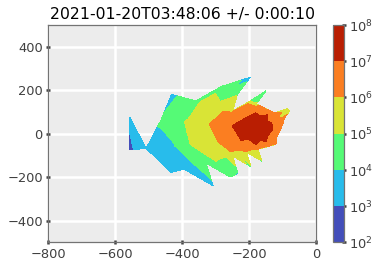

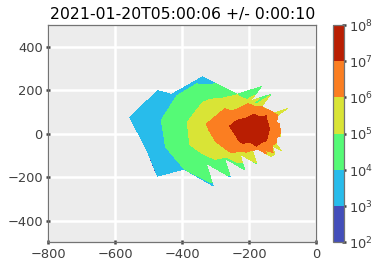

In [22]:

import datetime
# datetime(YYYY, mm, dd, HH, MM)
#timeSlice  = datetime.datetime(2020, 1, 29, 18, 10, 2)   # Original test slice

timeStart  = datetime.datetime(2021, 1, 20, 2, 14, 30)  
timeEnd  = timeStart + datetime.timedelta(seconds=10)
doitallRange(timeStart, timeEnd)

timeStart  = datetime.datetime(2021, 1, 20, 3, 48, 0)  
timeEnd  = timeStart + datetime.timedelta(seconds=10)
doitallRange(timeStart, timeEnd)

timeStart  = datetime.datetime(2021, 1, 20, 5, 0, 0)  
timeEnd  = timeStart + datetime.timedelta(seconds=10)
doitallRange(timeStart, timeEnd)


#timeStart  = datetime.datetime(2020, 1, 29, 20, 30, 0)  
#timeEnd  = timeStart + datetime.timedelta(seconds=10)
#doitallRange(timeStart, timeEnd)


#timeStart  = datetime.datetime(2020, 1, 29, 21, 0, 0)  
#timeEnd  = timeStart + datetime.timedelta(seconds=10)
#doitallRange(timeStart, timeEnd)